In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import math_ops
from ESN import EchoStateRNNCell
import matplotlib.pyplot as plt

# takes only current needed GPU memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = False

# random numbers
random_seed = 1
rng = np.random.RandomState(random_seed)

We define a simple simulation with a single batch. A timeseries of 'stime' timesteps is run. The input is a inpulse 
given in the first timestep consisting of a gaussian noise given to each unit.

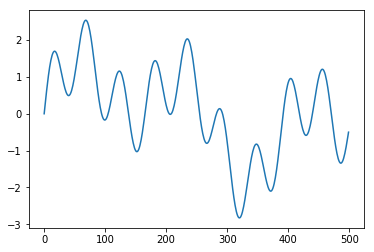

In [6]:
# Global variables
batches = 1
stime = 500
num_units = 20
num_inputs = 1
rnn_init_state = np.zeros([1, num_units], dtype="float32")
rnn_inputs = np.zeros((batches, stime, num_inputs), dtype="float32")
rnn_inputs[0, :, 0] = np.sin(np.linspace(0,18*np.pi, stime)) + \
                      np.sin(np.linspace(0,5.3*np.pi, stime)) + \
                      np.sin(np.linspace(0,2.1*np.pi, stime)) 
plt.plot(rnn_inputs[0,:,:])
plt.show()

activation = lambda x: math_ops.tanh(x)


Implementing a static graph without tensorflow API:

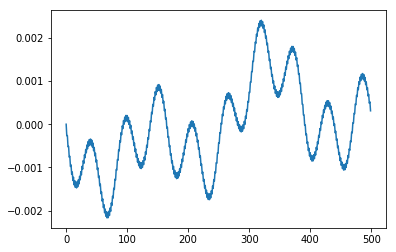

In [7]:
tf.reset_default_graph()
static_graph = tf.Graph()
with static_graph.as_default() as g:
        
    rng = np.random.RandomState(random_seed)

    # Init the ESN cell
    cell = EchoStateRNNCell(num_units=num_units, 
                            num_inputs=num_inputs,
                            activation=activation, 
                            decay=0.01, 
                            epsilon=1e-10,
                            alpha=0.0100,
                            rng=rng)
    
    inputs = tf.placeholder(tf.float32, [batches, stime, num_inputs])
    init_state = tf.placeholder(tf.float32, [1, num_units])
    
    # Build the graph
    states = []
    state = init_state
    for t in range(stime):
        prev_state = state
        out, state = cell(inputs=inputs[0,t:(t+1),:], state=prev_state)
        states.append(out)
    
    outputs = tf.reshape(states, [stime, num_units])

    # Run the simulation
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        curr_outputs = sess.run(outputs, feed_dict={inputs: rnn_inputs,
                                                   init_state: rnn_init_state})
        plt.plot(np.squeeze(curr_outputs))
        plt.show()

Implementing a dynamic graph using tensorflow API

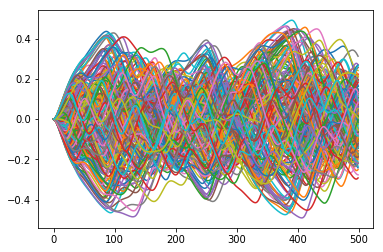

In [5]:
tf.reset_default_graph()
dynamic_graph = tf.Graph()
with dynamic_graph.as_default() as g:
    
    rng = np.random.RandomState(random_seed)

    # Init the ESN cell
    cell = EchoStateRNNCell(num_units=num_units, 
                            num_inputs=num_inputs,
                            activation=activation, 
                            decay=0.01, 
                            epsilon=1e-10,
                            alpha=0.100,
                            rng=rng)
    
    inputs = tf.placeholder(tf.float32, [batches, stime, num_inputs])
    init_state = tf.placeholder(tf.float32, [1, num_units])

    # Build the graph using the API
    states, final_state = tf.nn.dynamic_rnn(cell, 
                                            inputs, 
                                            initial_state=init_state)
    
    # tf.nn.dynamic_rnn returns the state, not the output of the cell
    outputs = tf.reshape(activation(states), [stime, num_units])
     
    # Run the simulation
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
                 
        stored_outputs = sess.run(outputs, feed_dict={inputs:rnn_inputs,
                                                   init_state:rnn_init_state})
                
        plt.plot(np.squeeze(stored_outputs))       
        plt.show()
        

Run  a simple training on the outputs